## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout

from keras.regularizers import l1_l2

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0.,
              l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=l1_l2(l1=0, l2=l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)

            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=l1_l2(l1=0, l2=l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""

LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 128

"""
建立實驗組合
"""
USE_BN = [True, False]
DRP_RATIO = [0.2, 0.5, 0.8]
L2_RATIO = [1e-2, 1e-5, 1e-8]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
import keras.backend as K


results = {}
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    K.clear_session()
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    #exp_name_tag = ("exp-%s" % (i))
    exp_name_tag = "exp-use_bn-%s-drp_ratio-%s-l2_ratio-%s" % (str(use_bn), str(drp_ratio),str(l2_ratio))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, with bn: True, drp_ratio: 0.20, l2_ratio: 0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
___________________________________________________________

/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (2.537971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.269811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


50000/50000 [==============================] - 38s 769us/step - loss: 1.7846 - accuracy: 0.3722 - val_loss: 1.6773 - val_accuracy: 0.4168
Epoch 2/3
50000/50000 [==============================] - 33s 652us/step - loss: 1.5512 - accuracy: 0.4505 - val_loss: 1.6454 - val_accuracy: 0.4191
Epoch 3/3
50000/50000 [==============================] - 38s 760us/step - loss: 1.4646 - accuracy: 0.4826 - val_loss: 1.5959 - val_accuracy: 0.4350
Numbers of exp: 2, with bn: True, drp_ratio: 0.20, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_____________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 31s 626us/step - loss: 2.0839 - accuracy: 0.2749 - val_loss: 1.7886 - val_accuracy: 0.3653
Epoch 2/3
50000/50000 [==============================] - 31s 624us/step - loss: 1.7784 - accuracy: 0.3657 - val_loss: 1.6651 - val_accuracy: 0.4215
Epoch 3/3
50000/50000 [==============================] - 31s 619us/step - loss: 1.6844 - accuracy: 0.4022 - val_loss: 1.6272 - val_accuracy: 0.4420
Numbers of exp: 5, with bn: True, drp_ratio: 0.50, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batc

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 31s 627us/step - loss: 2.7177 - accuracy: 0.1353 - val_loss: 2.1297 - val_accuracy: 0.2617
Epoch 2/3
50000/50000 [==============================] - 30s 600us/step - loss: 2.1583 - accuracy: 0.1932 - val_loss: 1.9885 - val_accuracy: 0.2801
Epoch 3/3
50000/50000 [==============================] - 34s 673us/step - loss: 2.0488 - accuracy: 0.2304 - val_loss: 1.9178 - val_accuracy: 0.3051
Numbers of exp: 8, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batc

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 39s 774us/step - loss: 2.0009 - accuracy: 0.2618 - val_loss: 1.7964 - val_accuracy: 0.3519
Epoch 2/3
50000/50000 [==============================] - 32s 638us/step - loss: 1.8491 - accuracy: 0.3260 - val_loss: 1.7479 - val_accuracy: 0.3742
Epoch 3/3
50000/50000 [==============================] - 32s 645us/step - loss: 1.7901 - accuracy: 0.3492 - val_loss: 1.6957 - val_accuracy: 0.3901
Numbers of exp: 12, with bn: False, drp_ratio: 0.50, l2_ratio: 0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 33s 670us/step - loss: 6.0969 - accuracy: 0.0974 - val_loss: 2.8058 - val_accuracy: 0.0972
Epoch 2/3
50000/50000 [==============================] - 40s 807us/step - loss: 2.4848 - accuracy: 0.1000 - val_loss: 2.3477 - val_accuracy: 0.1000
Epoch 3/3
50000/50000 [==============================] - 42s 833us/step - loss: 2.3216 - accuracy: 0.0991 - val_loss: 2.3084 - val_accuracy: 0.1000
Numbers of exp: 16, with bn: False, drp_ratio: 0.80, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)

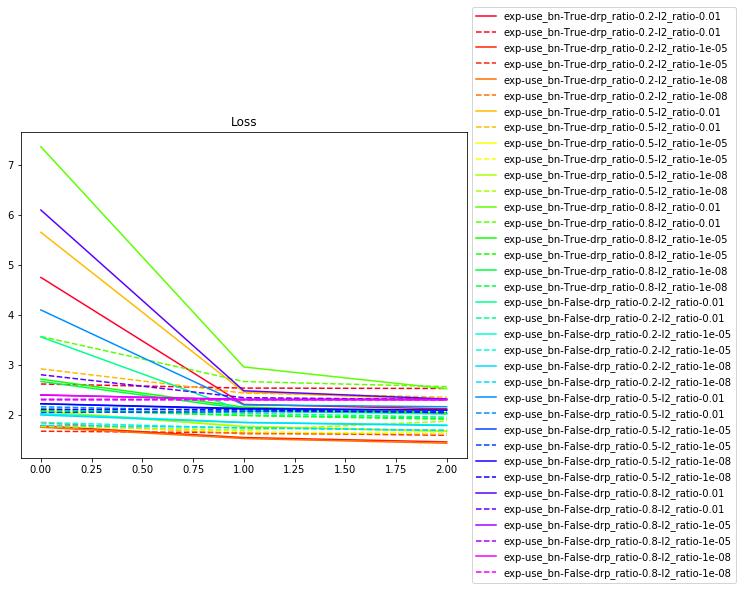

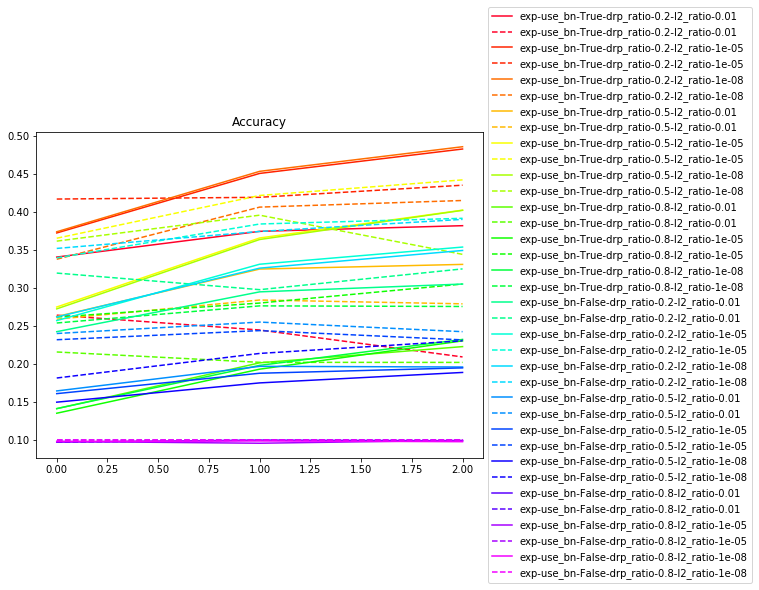

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()